In [19]:
import keras as k
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [178]:
(xtrainmaster, ytrainmaster),(xtestmaster,ytestmaster)=k.datasets.fashion_mnist.load_data()
xtrainmaster = xtrainmaster / 255
xtestmaster = xtestmaster / 255
ytrainmaster=ytrainmaster.flatten()
ytestmaster=ytestmaster.flatten()
xtrainmaster=np.expand_dims(xtrainmaster, 3)
xtestmaster=np.expand_dims(xtestmaster, 3)
print(xtrainmaster.shape)
print(xtestmaster.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [107]:
def generate_triplets(dataset, label, samples=10):
    x, y = None, None
    
    for i in range(10):
        posind = np.argwhere(label==i)[:,0]#index of images of same item
        negind = np.argwhere(label!=i)[:,0]#index of images of diff item
        
        choice_anchor=np.random.choice(posind.shape[0], samples, replace=False)
        choice_anchor=posind[choice_anchor]
        
        choice_pos=np.random.choice(posind.shape[0], samples, replace=False)
        choice_pos=posind[choice_pos]
        
        choice_neg=np.random.choice(negind.shape[0], samples, replace=False)
        choice_neg=negind[choice_neg]
        
        sub_x_anc=dataset[choice_anchor]
        
        sub_x_pos=dataset[choice_pos]
        
        sub_x_neg=dataset[choice_neg]
        
        if x is None:
            x = [(sub_x_anc),(sub_x_pos),(sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))
            
            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
            
    return x, y

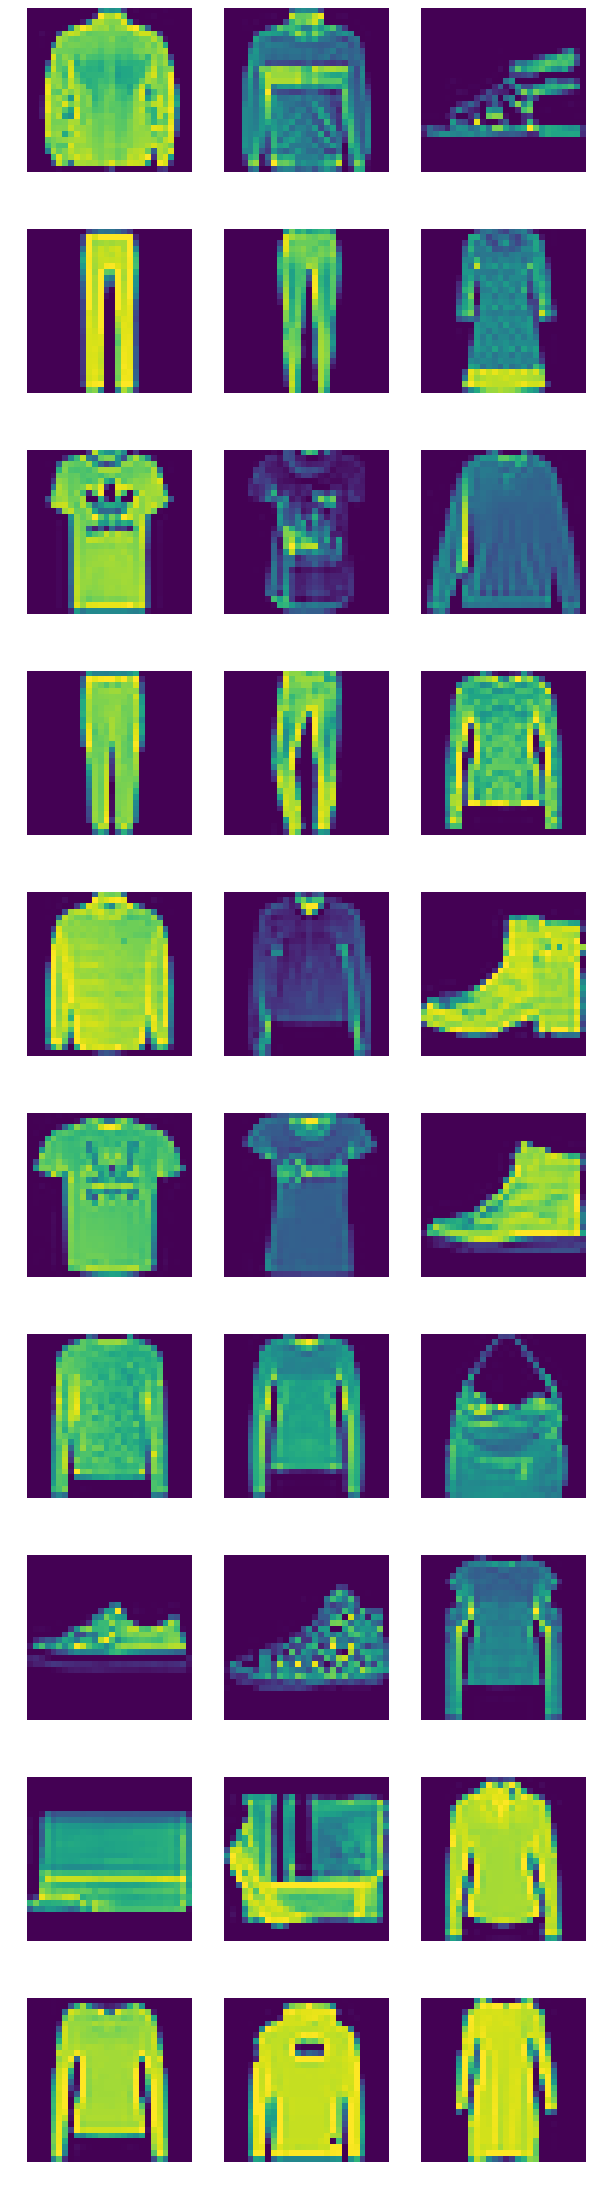

In [110]:
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=False)
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.reshape(anc[ch],(28,28)))
        ax[i, 1].imshow(np.reshape(pos[ch],(28,28)))
        ax[i, 2].imshow(np.reshape(neg[ch],(28,28)))
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    return random_choices

def visualize_data1(data):
    n = len(data[0])
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i in range(len(anc)):
        ax[i, 0].imshow(np.squeeze(anc[i]))
        ax[i, 1].imshow(np.squeeze(pos[i]))
        ax[i, 2].imshow(np.squeeze(neg[i]))
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    
x=visualize_data(train_x, 10)

In [167]:
ntpc = 1
train_x, train_y=generate_triplets(xtrainmaster, ytrainmaster, ntpc)
test_x, test_y=generate_triplets(xtestmaster, ytestmaster, 5)

print(np.shape(train_x), np.shape(test_x))

(3, 10, 784, 1, 1) (3, 50, 784, 1, 1)


In [163]:
def triplet_loss(inputs, distance='sqeuclidean', margin='maxplus'):
    anchor, positive, negative=inputs
    
    positive_dist = K.square(anchor-positive)
    negative_dist = K.square(anchor-negative)
    
    if distance is 'euclidean':
        positive_dist = K.sqrt(K.sum(positive_dist, axis=-1, keepdims=True))
        negative_dist = K.sqrt(K.sum(negative_dist, axis=-1, keepdims=True))
    
    elif distance is 'sqeuclidean':
        positive_dist = K.sum(positive_dist, axis=-1, keepdims=True)
        negative_dist = K.sum(negative_dist, axis=-1, keepdims=True)
    
    loss = positive_dist-negative_dist
    
    if margin == 'maxplus':
        loss = K.maximum(0.0, loss+1)
    
    elif margin == 'softplus':
        loss = K.log(1+K.exp(loss))
    
    return K.mean(loss)


def embeddings(input_shape,embedding_dim):
    _input = Input(shape=input_shape)
    x = Conv2D(8,(3,3))(_input)
    x = AveragePooling2D()(x)
    x = Activation('relu')(x)
    x = Conv2D(16,(2,2))(x)
    x = AveragePooling2D()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(_input, x)


def saimese(in_shape, triplet_margin=0.3, embedding_dims=50):
    anc_inp = Input(in_shape,name="anchorInput")
    pos_inp = Input(in_shape,name='positiveInput')
    neg_inp = Input(in_shape,name='negativeInput')
    
    embeddingModel = embeddings(in_shape,embedding_dims)
    
    encoded_anc = embeddingModel(anc_inp)
    encoded_pos = embeddingModel(pos_inp)
    encoded_neg = embeddingModel(neg_inp)
    
    inputs=[anc_inp, pos_inp, neg_inp]
    outputs=[encoded_anc, encoded_pos, encoded_neg]
    
    saimese_triplet = Model(inputs=inputs, outputs=outputs)
    
    saimese_triplet.add_loss((triplet_loss(outputs,'euclidean', 'maxplus')))
    
    return embeddingModel, saimese_triplet

embedding, smodel = saimese((28,28,1),0.3,150)
smodel.compile(loss=None, optimizer=Adam(0.0001))
print(embedding.summary())
print(smodel.summary())

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
average_pooling2d_3 (Average (None, 13, 13, 8)         0         
_________________________________________________________________
activation_10 (Activation)   (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 16)        528       
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
activation_11 (Activation)   (None, 6, 6, 16)          0  

C:\Users\Assessioner\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output model_23 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_23.
  'be expecting any data to be passed to {0}.'.format(name))


In [179]:
train_x, train_y = generate_triplets(xtrainmaster, ytrainmaster,100)
print(np.shape(train_x))

(3, 1000, 28, 28, 1)


In [185]:
history=smodel.fit(x=train_x, shuffle=True, batch_size=1000, validation_split=0.1,epochs=300)

Train on 900 samples, validate on 100 samples
Epoch 1/300
900/900 [==============================] - 0s 111us/step - loss: 0.1423 - val_loss: 0.1062
Epoch 2/300
900/900 [==============================] - 0s 127us/step - loss: 0.1425 - val_loss: 0.1061
Epoch 3/300
900/900 [==============================] - 0s 113us/step - loss: 0.1436 - val_loss: 0.1060
Epoch 4/300
900/900 [==============================] - 0s 107us/step - loss: 0.1404 - val_loss: 0.1058
Epoch 5/300
900/900 [==============================] - 0s 130us/step - loss: 0.1414 - val_loss: 0.1057
Epoch 6/300
900/900 [==============================] - 0s 120us/step - loss: 0.1382 - val_loss: 0.1056
Epoch 7/300
900/900 [==============================] - 0s 129us/step - loss: 0.1421 - val_loss: 0.1054
Epoch 8/300
900/900 [==============================] - 0s 158us/step - loss: 0.1359 - val_loss: 0.1053
Epoch 9/300
900/900 [==============================] - 0s 155us/step - loss: 0.1416 - val_loss: 0.1052
Epoch 10/300
900/900 [=====

Epoch 80/300
900/900 [==============================] - 0s 161us/step - loss: 0.1068 - val_loss: 0.1046
Epoch 81/300
900/900 [==============================] - 0s 161us/step - loss: 0.1093 - val_loss: 0.1045
Epoch 82/300
900/900 [==============================] - 0s 152us/step - loss: 0.1117 - val_loss: 0.1044
Epoch 83/300
900/900 [==============================] - 0s 123us/step - loss: 0.1056 - val_loss: 0.1044
Epoch 84/300
900/900 [==============================] - 0s 109us/step - loss: 0.1073 - val_loss: 0.1044
Epoch 85/300
900/900 [==============================] - 0s 105us/step - loss: 0.1168 - val_loss: 0.1045
Epoch 86/300
900/900 [==============================] - 0s 111us/step - loss: 0.1083 - val_loss: 0.1046
Epoch 87/300
900/900 [==============================] - 0s 109us/step - loss: 0.1053 - val_loss: 0.1048
Epoch 88/300
900/900 [==============================] - 0s 105us/step - loss: 0.1070 - val_loss: 0.1050
Epoch 89/300
900/900 [==============================] - 0s 113us

Epoch 159/300
900/900 [==============================] - 0s 159us/step - loss: 0.0891 - val_loss: 0.1061
Epoch 160/300
900/900 [==============================] - 0s 146us/step - loss: 0.0896 - val_loss: 0.1061
Epoch 161/300
900/900 [==============================] - 0s 148us/step - loss: 0.0894 - val_loss: 0.1060
Epoch 162/300
900/900 [==============================] - 0s 165us/step - loss: 0.0934 - val_loss: 0.1059
Epoch 163/300
900/900 [==============================] - 0s 158us/step - loss: 0.0870 - val_loss: 0.1059
Epoch 164/300
900/900 [==============================] - 0s 163us/step - loss: 0.0882 - val_loss: 0.1058
Epoch 165/300
900/900 [==============================] - 0s 154us/step - loss: 0.0889 - val_loss: 0.1057
Epoch 166/300
900/900 [==============================] - 0s 148us/step - loss: 0.0924 - val_loss: 0.1056
Epoch 167/300
900/900 [==============================] - 0s 123us/step - loss: 0.0893 - val_loss: 0.1055
Epoch 168/300
900/900 [==============================] 

900/900 [==============================] - 0s 154us/step - loss: 0.0715 - val_loss: 0.1038
Epoch 238/300
900/900 [==============================] - 0s 153us/step - loss: 0.0758 - val_loss: 0.1036
Epoch 239/300
900/900 [==============================] - 0s 152us/step - loss: 0.0734 - val_loss: 0.1035
Epoch 240/300
900/900 [==============================] - 0s 160us/step - loss: 0.0733 - val_loss: 0.1035
Epoch 241/300
900/900 [==============================] - 0s 146us/step - loss: 0.0705 - val_loss: 0.1035
Epoch 242/300
900/900 [==============================] - 0s 138us/step - loss: 0.0687 - val_loss: 0.1036
Epoch 243/300
900/900 [==============================] - 0s 146us/step - loss: 0.0743 - val_loss: 0.1037
Epoch 244/300
900/900 [==============================] - 0s 143us/step - loss: 0.0722 - val_loss: 0.1036
Epoch 245/300
900/900 [==============================] - 0s 140us/step - loss: 0.0709 - val_loss: 0.1036
Epoch 246/300
900/900 [==============================] - 0s 129us/ste

In [186]:
evaluate(test_x,1000)

(3, 1000, 150)
accuracy 0.779


In [183]:
test_x, test_y = generate_triplets(xtestmaster, ytestmaster, 1000)
print(np.shape(test_x))

(3, 10000, 28, 28, 1)


In [135]:
def gen_test(test_x,size):
    anc,pos,neg = test_x
#     print(len(a))
    random_choice=np.random.choice(anc.shape[0], size, replace=False)
#     print(random_choice)
    x,y=None,None
    for i in random_choice:
        sanc=np.expand_dims(anc[i],0)
        if np.random.choice([True,False]):
            spos=np.expand_dims(pos[i],0)
            sneg=np.expand_dims(neg[i],0)
            sy=1
        else:
            spos=np.expand_dims(neg[i],0)
            sneg=np.expand_dims(pos[i],0)
            sy=0
        if x is None:
            x=[(sanc),(spos),(sneg)]
            y=[sy]
        else:
            x[0] = np.vstack((x[0],(sanc)))
            x[1] = np.vstack((x[1],(spos)))
            x[2] = np.vstack((x[2],(sneg)))
            y.append(sy)
    return x,y

def evaluate(dataset,size):
    testsetx,testsety=gen_test(dataset,size)
    res = smodel.predict(testsetx)
    res = np.asarray(res)
    print(res.shape)
    anc,pos,neg=res
    x=[0]
    # random_choices=[0,1,2,3]
    # visualize_data1(test_x, [0,1,2,3])
    ypred=[]
    for i in range(len(res[0])):
        s=abs(sum(anc[i]-pos[i]))<abs(sum(anc[i]-neg[i]))
        if s:
            ypred.append(1)
        else:
            ypred.append(0)
    # print(testsety,ypred)
    diff=1-(np.sum(abs(np.diff((testsety,ypred),axis=0)))/len(ypred))
    print('accuracy {}'.format(diff))
